# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 5, 5
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block_16_expand', 'lock_16_project', 'block_16_project_BN']
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.7317

947/947 [==============================] - 2701s 3s/step - loss: 0.8279 - accuracy: 0.7317 - val_loss: 7.8605 - val_accuracy: 0.6617
Epoch 2/200
947/947 [==============================] - 2497s 3s/step - loss: 0.7114 - accuracy: 0.7589 - val_loss: 9.5596 - val_accuracy: 0.6744
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.7685

947/947 [==============================] - 2649s 3s/step - loss: 0.6685 - accuracy: 0.7685 - val_loss: 2.9098 - val_accuracy: 0.6808
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6430 - accuracy: 0.7759

947/947 [==============================] - 2578s 3s/step - loss: 0.6430 - accuracy: 0.7759 - val_loss: 1.4562 - val_accuracy: 0.6698
Epoch 5/200
947/947 [==============================] - 2504s 3s/step - loss: 0.6163 - accuracy: 0.7836 - val_loss: 2.3681 - val_accuracy: 0.5693
Epoch 6/200
947/947 [==============================] - 2498s 3s/step - loss: 0.5935 - accuracy: 0.7922 - val_loss: 1.5706 - val_accuracy: 0.5940
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5775 - accuracy: 0.7972

947/947 [==============================] - 2593s 3s/step - loss: 0.5775 - accuracy: 0.7972 - val_loss: 1.2262 - val_accuracy: 0.6831
Epoch 8/200
947/947 [==============================] - 2505s 3s/step - loss: 0.5652 - accuracy: 0.7998 - val_loss: 1.3651 - val_accuracy: 0.7319
Epoch 9/200
947/947 [==============================] - 2504s 3s/step - loss: 0.5479 - accuracy: 0.8062 - val_loss: 1.3420 - val_accuracy: 0.6708
Epoch 10/200
947/947 [==============================] - ETA: 0s - loss: 0.5378 - accuracy: 0.8089

947/947 [==============================] - 2581s 3s/step - loss: 0.5378 - accuracy: 0.8089 - val_loss: 1.0915 - val_accuracy: 0.7088
Epoch 11/200
947/947 [==============================] - 2498s 3s/step - loss: 0.5313 - accuracy: 0.8127 - val_loss: 1.7857 - val_accuracy: 0.7012
Epoch 12/200
947/947 [==============================] - 2501s 3s/step - loss: 0.5155 - accuracy: 0.8181 - val_loss: 1.3445 - val_accuracy: 0.6489
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.8192

947/947 [==============================] - 2595s 3s/step - loss: 0.5068 - accuracy: 0.8192 - val_loss: 0.8194 - val_accuracy: 0.7349
Epoch 14/200
947/947 [==============================] - 2489s 3s/step - loss: 0.4989 - accuracy: 0.8221 - val_loss: 1.0548 - val_accuracy: 0.7201
Epoch 15/200
947/947 [==============================] - 2495s 3s/step - loss: 0.4884 - accuracy: 0.8255 - val_loss: 0.9450 - val_accuracy: 0.6802
Epoch 16/200
947/947 [==============================] - 2493s 3s/step - loss: 0.4809 - accuracy: 0.8276 - val_loss: 0.8981 - val_accuracy: 0.7300
Epoch 17/200
947/947 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.8328

947/947 [==============================] - 2569s 3s/step - loss: 0.4702 - accuracy: 0.8328 - val_loss: 0.6726 - val_accuracy: 0.7823
Epoch 18/200
947/947 [==============================] - 2497s 3s/step - loss: 0.4675 - accuracy: 0.8346 - val_loss: 1.1659 - val_accuracy: 0.7494
Epoch 19/200
947/947 [==============================] - 2500s 3s/step - loss: 0.4599 - accuracy: 0.8356 - val_loss: 0.7444 - val_accuracy: 0.7859
Epoch 20/200
947/947 [==============================] - 2489s 3s/step - loss: 0.4494 - accuracy: 0.8390 - val_loss: 1.0936 - val_accuracy: 0.7062
Epoch 21/200
947/947 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.8407

947/947 [==============================] - 2573s 3s/step - loss: 0.4405 - accuracy: 0.8407 - val_loss: 0.6676 - val_accuracy: 0.8013
Epoch 22/200
947/947 [==============================] - 2485s 3s/step - loss: 0.4334 - accuracy: 0.8450 - val_loss: 0.9010 - val_accuracy: 0.7539
Epoch 23/200
947/947 [==============================] - 2496s 3s/step - loss: 0.4274 - accuracy: 0.8453 - val_loss: 0.8814 - val_accuracy: 0.7596
Epoch 24/200
947/947 [==============================] - 2484s 3s/step - loss: 0.4241 - accuracy: 0.8483 - val_loss: 0.7472 - val_accuracy: 0.7811
Epoch 25/200
947/947 [==============================] - 2488s 3s/step - loss: 0.4188 - accuracy: 0.8490 - val_loss: 0.7272 - val_accuracy: 0.7567
Epoch 26/200
947/947 [==============================] - 2499s 3s/step - loss: 0.4114 - accuracy: 0.8505 - val_loss: 1.1066 - val_accuracy: 0.6567
Epoch 27/200
947/947 [==============================] - ETA: 0s - loss: 0.4083 - accuracy: 0.8556

947/947 [==============================] - 2581s 3s/step - loss: 0.4083 - accuracy: 0.8556 - val_loss: 0.6420 - val_accuracy: 0.7852
Epoch 28/200
947/947 [==============================] - 2481s 3s/step - loss: 0.3983 - accuracy: 0.8550 - val_loss: 1.1438 - val_accuracy: 0.6600
Epoch 29/200
947/947 [==============================] - 2483s 3s/step - loss: 0.3929 - accuracy: 0.8590 - val_loss: 0.7898 - val_accuracy: 0.7696
Epoch 30/200
947/947 [==============================] - 2500s 3s/step - loss: 0.3908 - accuracy: 0.8588 - val_loss: 0.9521 - val_accuracy: 0.7434
Epoch 31/200
947/947 [==============================] - 2499s 3s/step - loss: 0.3875 - accuracy: 0.8607 - val_loss: 1.1292 - val_accuracy: 0.6866
Epoch 32/200
947/947 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.8624

947/947 [==============================] - 2567s 3s/step - loss: 0.3766 - accuracy: 0.8624 - val_loss: 0.5999 - val_accuracy: 0.8021
Epoch 33/200
947/947 [==============================] - 2489s 3s/step - loss: 0.3721 - accuracy: 0.8656 - val_loss: 0.7076 - val_accuracy: 0.7760
Epoch 34/200
947/947 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8650

947/947 [==============================] - 2574s 3s/step - loss: 0.3667 - accuracy: 0.8650 - val_loss: 0.5845 - val_accuracy: 0.8130
Epoch 35/200
947/947 [==============================] - 2494s 3s/step - loss: 0.3642 - accuracy: 0.8682 - val_loss: 0.6268 - val_accuracy: 0.8078
Epoch 36/200
947/947 [==============================] - 2491s 3s/step - loss: 0.3557 - accuracy: 0.8706 - val_loss: 0.7016 - val_accuracy: 0.7974
Epoch 37/200
947/947 [==============================] - 2490s 3s/step - loss: 0.3529 - accuracy: 0.8718 - val_loss: 0.8509 - val_accuracy: 0.7502
Epoch 38/200
947/947 [==============================] - 2476s 3s/step - loss: 0.3433 - accuracy: 0.8751 - val_loss: 0.8426 - val_accuracy: 0.7500
Epoch 39/200
947/947 [==============================] - 2491s 3s/step - loss: 0.3425 - accuracy: 0.8751 - val_loss: 0.9098 - val_accuracy: 0.7193
Epoch 40/200
947/947 [==============================] - 2486s 3s/step - loss: 0.3362 - accuracy: 0.8773 - val_loss: 0.7754 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 294s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9613781098056764,
 'basal cell carcinoma': 0.9781593067719254,
 'dermatofibroma': 0.9840709133226588,
 'melanoma': 0.9216412806585061,
 'nevus': 0.9596080694327281,
 'pigmented benign keratosis': 0.9655121499334556,
 'seborrheic keratosis': 0.9520617212111484,
 'solar lentigo': 0.9737089029124427,
 'squamous cell carcinoma': 0.9488139015069579,
 'vascular lesion': 0.9984531501042628}

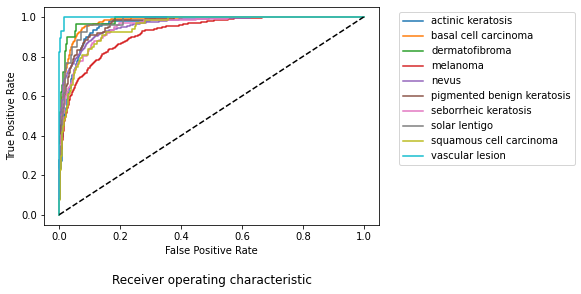

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

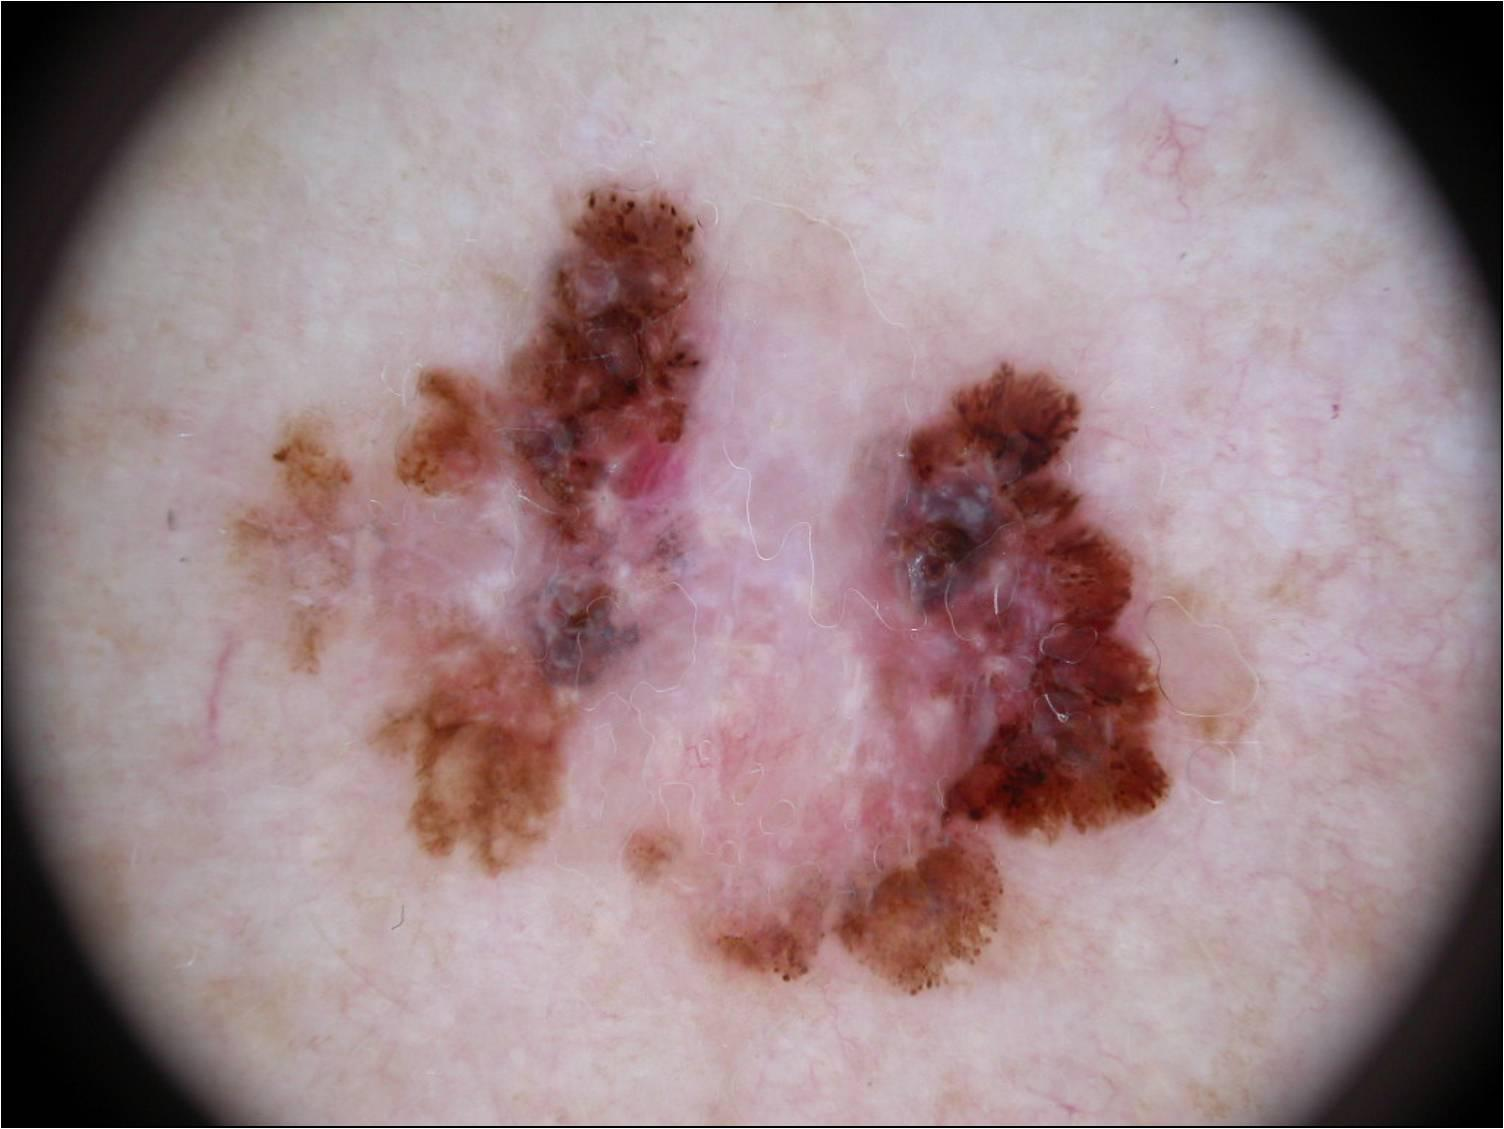

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

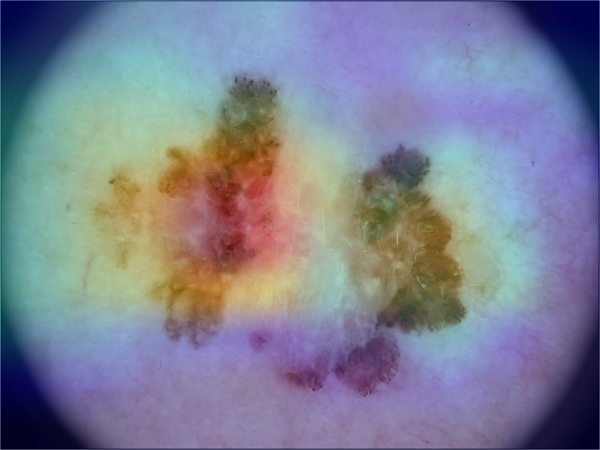

In [23]:
display_gradcam(melanoma_im_path, heatmap)